In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# قراءة البيانات
data = pd.read_csv('/content/data_arrhythmia.csv', sep=';')
data.head()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


(452, 280)
Index(['age', 'sex', 'height', 'weight', 'qrs_duration', 'p-r_interval',
       'q-t_interval', 't_interval', 'p_interval', 'qrs',
       ...
       'KY', 'KZ', 'LA', 'LB', 'LC', 'LD', 'LE', 'LF', 'LG', 'diagnosis'],
      dtype='object', length=280)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, age to diagnosis
dtypes: float64(121), int64(159)
memory usage: 988.9 KB
None
              age         sex      height      weight  qrs_duration  \
count  452.000000  452.000000  452.000000  452.000000    452.000000   
mean    46.471239    0.550885  166.188053   68.170354     88.920354   
std     16.466631    0.497955   37.170340   16.590803     15.364394   
min      0.000000    0.000000  105.000000    6.000000     55.000000   
25%     36.000000    0.000000  160.000000   59.000000     80.000000   
50%     47.000000    1.000000  164.000000   68.000000     86.000000   
75%     58.000000    1.000000  170.000000   79.000000     94.000000  

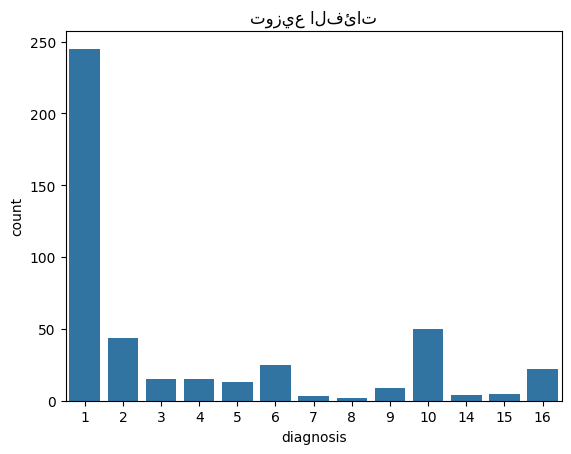

In [ ]:
# نظرة عامة على البيانات
print(data.shape)  # عدد الصفوف والأعمدة
print(data.columns)  # أسماء الأعمدة
print(data.info())  # أنواع البيانات والـ nulls
print(data.describe())  # إحصائيات وصفية للمتغيرات العددية

# التحقق من القيم المفقودة
print(data.isnull().sum())

# توزيع الفئات المستهدفة (target)
sns.countplot(x='diagnosis', data=data)
plt.title('توزيع الفئات')
plt.show()

In [ ]:
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
numeric_cols = data.select_dtypes(include='number').columns

# إنشاء Subplots للتوزيعات
rows = len(numeric_cols)
fig = sp.make_subplots(rows=rows, cols=1, subplot_titles=numeric_cols)

for i, col in enumerate(numeric_cols, start=1):
    fig.add_trace(
        go.Histogram(x=data[col], name=col),
        row=i, col=1
    )

fig.update_layout(height=300*rows, width=800, title_text="توزيع جميع الأعمدة الرقمية", showlegend=False)
fig.show()

In [ ]:
skewness = data[numeric_cols].skew()
print(skewness)

age             -0.286886
sex             -0.205284
height          13.723838
weight           0.167132
qrs_duration     2.565716
                  ...    
LD              -0.289642
LE              -0.647555
LF               0.433284
LG               0.299452
diagnosis        1.487672
Length: 280, dtype: float64


In [ ]:
skewed_cols = skewness[abs(skewness) > 0.5].index

for col in skewed_cols:
    if (data[col] > 0).all():
        data[col] = np.log1p(data[col])  # log(1+x) لتجنب الصفر


In [ ]:
for col in skewed_cols:
    fig = px.histogram(data, x=col, nbins=50, title=f"Distribution of {col} after transformation")
    fig.show()

In [ ]:
# استبدال '?' بـ NaN
data = data.replace('?', np.nan)

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# تعويض القيم الفارغة بمتوسط العمود
data.fillna(data.mean(), inplace=True)

In [ ]:
# تحديد المتغيرات المستقلة والمتغير المعتمد
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

# تقسيم البيانات إلى مجموعات التدريب والاختبار
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# تسوية البيانات
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.7032967032967034


In [ ]:
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial'),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(),
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.3f}")

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default 

Logistic Regression: Mean Accuracy = 0.667


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Random Forest: Mean Accuracy = 0.715
KNN: Mean Accuracy = 0.585


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
# تطوير نموذج تنبؤ باستخدام الشبكات العصبونية العميقة
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, verbose=1)
dl_loss, dl_accuracy = model.evaluate(X_test_scaled, y_test)
print("Deep Learning Accuracy:", dl_accuracy)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4650 - loss: -1.0604
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5513 - loss: -7.2068  
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5378 - loss: -14.3811 
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5736 - loss: -22.9014 
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5436 - loss: -39.8392 
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5439 - loss: -56.1902 
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5662 - loss: -91.6850 
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5668 - loss: -120.6405 
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5269 - loss: -196.7532 
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5660 - loss: -283.2891 
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5641 - loss: -361.8295 
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.6483516483516484
              precision    recall  f1-score   support

           1       0.64      0.86      0.74        44
           2       0.38      0.43      0.40         7
           3       1.00      0.80      0.89         5
           4       0.50      1.00      0.67         1
           5       0.00      0.00      0.00         2
           6       1.00      0.17      0.29         6
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         1
          10       0.77      0.62      0.69        16
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         6

    accuracy                           0.65        91
   macro avg       0.52      0.49      0.47        91
weighted avg       0.62      0.65      0.61        91



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
svm = SVC(kernel='rbf', gamma='scale')
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

SVM Accuracy: 0.5274725274725275
              precision    recall  f1-score   support

           1       0.51      1.00      0.68        44
           2       0.50      0.14      0.22         7
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       1.00      0.19      0.32        16
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         6

    accuracy                           0.53        91
   macro avg       0.17      0.11      0.10        91
weighted avg       0.46      0.53      0.40        91



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN Accuracy: 0.5714285714285714


In [ ]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.7142857142857143


In [ ]:
# age	عمر المريض (سنة)
# sex	الجنس (0=ذكر، 1=أنثى)
# height	الطول (سم)
# weight	الوزن (كجم)
# qrs_duration	مدة مركب QRS في ECG (ميلي ثانية)
# p-r_interval	فترة P-R (ميلي ثانية)
# q-t_interval	فترة Q-T (ميلي ثانية)
# t_interval	فترة موجة T (ميلي ثانية)
# p_interval	فترة موجة P (ميلي ثانية)
# qrs	قياس مركب QRS (عدة أنواع من القيم)
# ...	... باقي قياسات ECG كثيرة جداً
# KY, KZ, ...	قياسات متقدمة / مشتقات إحصائية أو طبية من الإشارات
# LA حتى LG	قياسات إضافية لفترات أو موجات ECG
# diagnosis	تصنيف اضطراب نظم القلب (1 إلى 16)

In [ ]:
# Perceptron
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
perceptron.fit(X_train, y_train)
y_pred_perceptron = perceptron.predict(X_test)

print("Perceptron Accuracy:", accuracy_score(y_test, y_pred_perceptron))
print(classification_report(y_test, y_pred_perceptron))

# MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

Perceptron Accuracy: 0.5164835164835165
              precision    recall  f1-score   support

           1       0.65      0.70      0.67        44
           2       0.28      0.71      0.40         7
           3       0.75      0.60      0.67         5
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         1
           9       0.50      1.00      0.67         1
          10       1.00      0.31      0.48        16
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.15      0.33      0.21         6

    accuracy                           0.52        91
   macro avg       0.28      0.31      0.26        91
weighted avg       0.57      0.52      0.50        91



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP Accuracy: 0.5164835164835165
              precision    recall  f1-score   support

           1       0.65      0.70      0.67        44
           2       0.40      0.57      0.47         7
           3       1.00      0.80      0.89         5
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.78      0.44      0.56        16
          14       0.00      0.00      0.00         1
          15       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         6

    accuracy                           0.52        91
   macro avg       0.29      0.27      0.28        91
weighted avg       0.55      0.52      0.52        91



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
